In [9]:
# Define the model
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))

model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


import pandas as pd
import re
import os

root = '../own_data_train'
# Lista plików (zakładając, że masz już listę plików, np. z os.listdir)
file_list = os.listdir(root)  # Zastąp 'ścieżka_do_twojego_folderu' odpowiednią ścieżką

# Inicjalizacja listy do przechowywania danych
data = []

# Iteracja po liście plików
for filename in file_list:
    # Wydobywanie liczby całkowitej z nazwy pliku przy użyciu wyrażenia regularnego
    match = re.search(r'\d+', filename)  # Zakładając, że liczba całkowita składa się z co najmniej jednej cyfry
    if match:
        integer = int(match.group())
        data.append({'cycles': integer, 'filename': filename[:-4]})

# Konwersja listy do DataFrame
df = pd.DataFrame(data, columns=['cycles', 'filename'])
# print(type(df["cycles"][0]))
df

import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split

# Parametry zduplikowania
duplication_factor = 1  # Ilość zduplikowania danych

# Wczytanie danych z CSV
audio_data = root + "/"
# df = pd.read_csv('cycles_count_own_data.csv', names=['Start', 'filename'], header=0)
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

def mfcc_feature_extraction_rr(dir_):
    X_ = []
    y_ = []
    data = df
    features = 50
    for soundDir in os.listdir(dir_):
        if soundDir[-3:] == 'wav':
            label = list(data[data['filename'] == (soundDir[:-4])]['cycles'])[0]               
            data_x, sampling_rate = librosa.load(dir_ + soundDir, res_type='kaiser_fast')
            audio_length = librosa.get_duration(filename=f'{root}/{soundDir}')
            label = label / (audio_length / 60)
            mfccs = np.mean(librosa.feature.mfcc(
                y=data_x, 
                sr=sampling_rate, 
                n_mfcc=features,
            ).T, axis=0)
            # Dodajemy cechy i etykiety
            X_.append(mfccs)
            y_.append(label)
            
            data_shift = shift(data_x,1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x,0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_noise)
            y_.append(label)
    
    # Zduplikowanie danych
    print(X_)
    X_data = np.tile(np.array(X_), (duplication_factor, 1))
    y_data = np.tile(np.array(y_), duplication_factor)
    
    return X_data, y_data

# Wywołanie funkcji ekstrakcji cech
res_data, res_y = mfcc_feature_extraction_rr(audio_data)


# # Podział danych na zbiory treningowe, walidacyjne i testowe
x_train, x_val, y_train, y_val = train_test_split(res_data, res_y, test_size=0.2, random_state=10)

# Wyświetlenie rozmiarów zbiorów danych

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)

from tensorflow.keras.models import load_model
import tensorflow as tf

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    x_train_lstm, y_train, batch_size=8, epochs=500, validation_data=(x_val_lstm, y_val),
  )

# Zapisz zaktualizowany model
model.save("model.h5")
model.save_weights('model.weights.h5')
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

C:\Users\u144572\AppData\Local\Temp\ipykernel_26756\1087625772.py:114: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_length = librosa.get_duration(filename=f'{root}/{soundDir}')


[array([-5.1379517e+02,  7.0679398e+01,  4.3663944e+01,  2.5943022e+01,
        1.7552425e+01,  1.3970831e+01,  1.2005817e+01,  1.0426517e+01,
        8.8623152e+00,  7.2997131e+00,  5.6002421e+00,  4.7479177e+00,
        3.8321173e+00,  3.3234153e+00,  2.8627179e+00,  2.4872894e+00,
        1.8726395e+00,  1.3499932e+00,  1.1436242e+00,  1.0029428e+00,
        8.7758744e-01,  5.3978658e-01,  3.1905678e-01,  1.8544845e-01,
       -6.7266077e-02, -4.7878888e-01, -3.0641991e-01, -1.5378450e-01,
       -1.2688722e-01, -7.8650691e-02, -3.0830806e-01, -6.9783336e-01,
       -8.4024298e-01, -8.4874672e-01, -6.8763340e-01, -5.3691286e-01,
       -6.2386465e-01, -8.0765551e-01, -8.9794040e-01, -9.2184359e-01,
       -1.1379633e+00, -1.1548047e+00, -9.5758337e-01, -8.5066849e-01,
       -7.5779086e-01, -6.7394185e-01, -7.8075391e-01, -8.5865623e-01,
       -1.0216365e+00, -1.0674158e+00], dtype=float32), array([-5.14328369e+02,  7.11415253e+01,  4.36495323e+01,  2.59175072e+01,
        1.756545

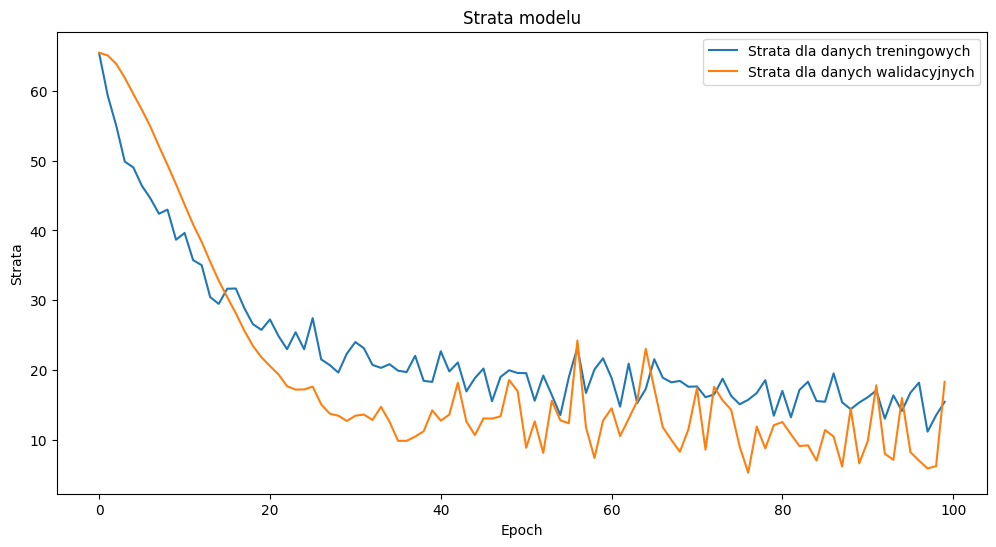

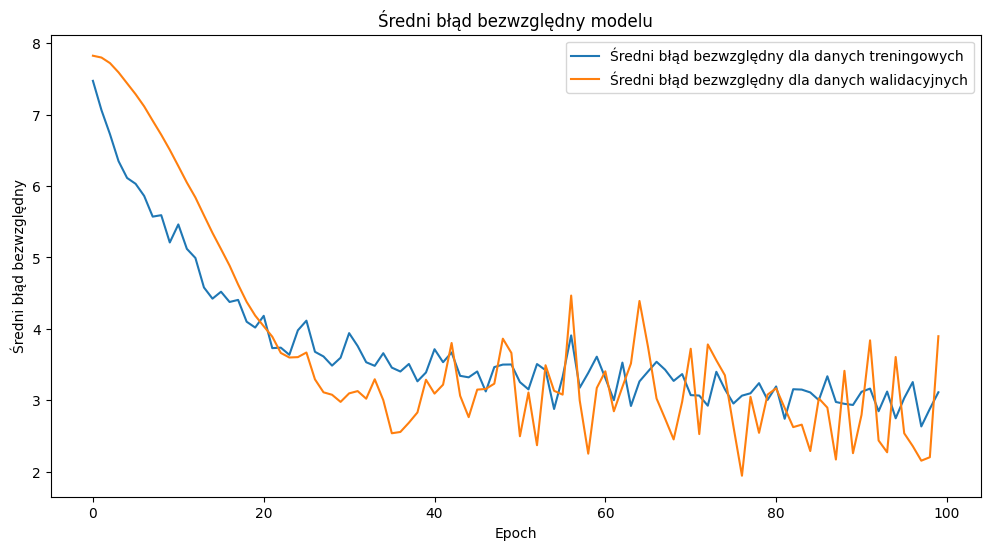

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("model.h5")
model.load_weights('model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

